In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import itertools
import os

In [128]:
res_path = r"F:\Muthu_2023\Personal\NextStep\CVProjects\SodiumDisposal\Output\Run1"

In [140]:
consolidated_df = pd.DataFrame()
for file in os.listdir(res_path):
    if '.csv' in file:
        df = pd.read_csv(res_path + "/" + file)
        if len(consolidated_df) == 0:
            consolidated_df = df
        else:
            consolidated_df = pd.concat([consolidated_df, df])
consolidated_df.head()

,Unnamed: 0,exp,video,segment,frame,n_masks,mask_area,mask_centroid,mask_conf,mask_strength,bbox_id,bbox_area,bbox_centroid,bbox_dim
0,0,04_07_2024,2024-07-04_11_51_08_772,2.0,100.0,1.0,[48],"[[277.0, 155.0]]",[0.38094273],[199.52],[0],[56.0],"[[277.0, 155.0]]","[[8.0, 7.0]]"
1,0,04_07_2024,2024-07-04_11_51_08_772,2.0,101.0,[],[],[],[],[],[],[],[],[]
2,0,04_07_2024,2024-07-04_11_51_08_772,2.0,102.0,[],[],[],[],[],[],[],[],[]
3,0,04_07_2024,2024-07-04_11_51_08_772,2.0,103.0,2,"[118, 198]","[[282.0, 164.0], [281.0, 162.0]]","[0.58505154, 0.40290353]","[198.36, 198.99]","[0, 0]","[126.0, 240.0]","[[282.0, 164.0], [281.0, 162.0]]","[[9.0, 14.0], [12.0, 20.0]]"
4,0,04_07_2024,2024-07-04_11_51_08_772,2.0,104.0,2,"[118, 198]","[[282.0, 164.0], [281.0, 162.0]]","[0.5849741, 0.40308228]","[198.36, 198.99]","[0, 0]","[126.0, 240.0]","[[282.0, 164.0], [281.0, 162.0]]","[[9.0, 14.0], [12.0, 20.0]]"


In [141]:
data = consolidated_df.copy()

# Data Preprocessing

In [142]:
list_cols = ['mask_area','mask_centroid','mask_conf','mask_strength','bbox_id','bbox_area','bbox_centroid','bbox_dim']

In [143]:
data.columns

Index(['Unnamed: 0', 'exp', 'video', 'segment', 'frame', 'n_masks',
       'mask_area', 'mask_centroid', 'mask_conf', 'mask_strength', 'bbox_id',
       'bbox_area', 'bbox_centroid', 'bbox_dim'],
      dtype='object')

In [144]:
def safe_literal_eval(val):
    try:
        if isinstance(val, str) and val.strip() not in ['', '[]']:
            return ast.literal_eval(val)
        else:
            return []  # or np.nan if you prefer
    except:
        return []  # or np.nan

In [ ]:
data.drop("Unnamed: 0", axis=1, inplace=True)

In [146]:
data['n_masks'] = data['n_masks'].apply(lambda x: 0 if x =='[]' else int(float(x)))
for col in list_cols:
    data[col] = data[col].apply(safe_literal_eval)
data.head()

,exp,video,segment,frame,n_masks,mask_area,mask_centroid,mask_conf,mask_strength,bbox_id,bbox_area,bbox_centroid,bbox_dim
0,04_07_2024,2024-07-04_11_51_08_772,2.0,100.0,1,[48],"[[277.0, 155.0]]",[0.38094273],[199.52],[0],[56.0],"[[277.0, 155.0]]","[[8.0, 7.0]]"
1,04_07_2024,2024-07-04_11_51_08_772,2.0,101.0,0,[],[],[],[],[],[],[],[]
2,04_07_2024,2024-07-04_11_51_08_772,2.0,102.0,0,[],[],[],[],[],[],[],[]
3,04_07_2024,2024-07-04_11_51_08_772,2.0,103.0,2,"[118, 198]","[[282.0, 164.0], [281.0, 162.0]]","[0.58505154, 0.40290353]","[198.36, 198.99]","[0, 0]","[126.0, 240.0]","[[282.0, 164.0], [281.0, 162.0]]","[[9.0, 14.0], [12.0, 20.0]]"
4,04_07_2024,2024-07-04_11_51_08_772,2.0,104.0,2,"[118, 198]","[[282.0, 164.0], [281.0, 162.0]]","[0.5849741, 0.40308228]","[198.36, 198.99]","[0, 0]","[126.0, 240.0]","[[282.0, 164.0], [281.0, 162.0]]","[[9.0, 14.0], [12.0, 20.0]]"


# Data Transformation

In [147]:
def calc_dim(val, ind):
    val = np.array(val)
    if val.ndim == 1 and len(val) > 1: #Single Box
        return val[ind]
    elif val.ndim > 1: # More than 1 Box
        if len(val[:,0]) == 0:
            return -1
        return np.mean(val[:,0])
    else: # 0 Box
        return 0   

In [148]:
def calc_pair_distance(val):
    pair_distances = [np.linalg.norm(np.array(p1) - np.array(p2)) for p1, p2 in itertools.combinations(val, 2)]
    if len(pair_distances) != 0:    
        return np.round(sum(pair_distances) / len(pair_distances),2)
    else:
        return 0

In [149]:
data['avg_mask_area'] = data['mask_area'].apply(lambda x: np.mean(x)).fillna(0)
data['avg_bbox_area'] = data['bbox_area'].apply(lambda x: np.mean(x)).fillna(0)
data['avg_mask_strength'] = data['mask_strength'].apply(lambda x: np.mean(x)).fillna(0)
data['avg_bbox_width'] = data['bbox_dim'].apply(lambda x: calc_dim(x, 0))
data['avg_bbox_height'] = data['bbox_dim'].apply(lambda x: calc_dim(x, 1))
data['mask_centroid_dist'] = data['mask_centroid'].apply(calc_pair_distance)
data['bbox_centroid_dist'] = data['bbox_centroid'].apply(calc_pair_distance)

C:\Users\ADMIN\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ADMIN\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ADMIN\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [150]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26857 entries, 0 to 3365
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   exp                 26857 non-null  object 
 1   video               26857 non-null  object 
 2   segment             26857 non-null  float64
 3   frame               26857 non-null  float64
 4   n_masks             26857 non-null  int64  
 5   mask_area           26857 non-null  object 
 6   mask_centroid       26857 non-null  object 
 7   mask_conf           26857 non-null  object 
 8   mask_strength       26857 non-null  object 
 9   bbox_id             26857 non-null  object 
 10  bbox_area           26857 non-null  object 
 11  bbox_centroid       26857 non-null  object 
 12  bbox_dim            26857 non-null  object 
 13  avg_mask_area       26857 non-null  float64
 14  avg_bbox_area       26857 non-null  float64
 15  avg_mask_strength   26857 non-null  float64
 16  avg_b

In [152]:
data.to_csv("Consolidated_Results.csv", index=False)

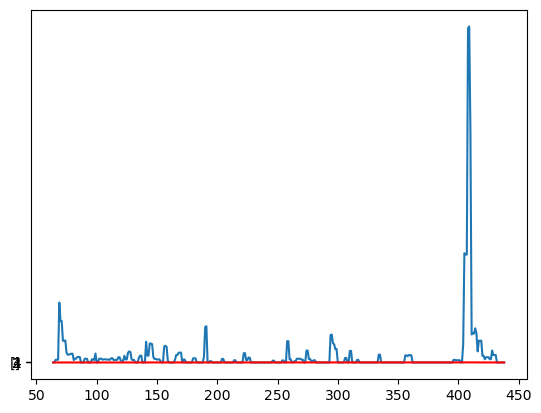

In [35]:
data

# Prepared by Muthukumar